In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Daily_running_shoes_supervised.csv", index_col = "Date")

In [3]:
df.head(5)

,T-28,T-27,T-26,T-25,T-24,T-23,T-22,T-21,T-20,T-19,...,difference_28_1-5,difference_28_1-4,difference_28_1-3,difference_28_1-2,difference_28_1-1,difference_statistic_28_1_mean,tzero,Target_Tplus1,week_day,week_number
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-30,136.0,5.0,30.0,2146.0,2066.0,619.0,373.0,4.0,1071.0,1420.0,...,35.0,-77.0,-125.0,-56.0,232.0,25.000000,680,1058.0,6,26
2019-07-01,5.0,30.0,2146.0,2066.0,619.0,373.0,4.0,1071.0,1420.0,214.0,...,-77.0,-125.0,-56.0,232.0,378.0,38.074074,1058,1064.0,0,27
2019-07-02,30.0,2146.0,2066.0,619.0,373.0,4.0,1071.0,1420.0,214.0,1053.0,...,-125.0,-56.0,232.0,378.0,6.0,-40.074074,1064,1118.0,1,27
2019-07-03,2146.0,2066.0,619.0,373.0,4.0,1071.0,1420.0,214.0,1053.0,368.0,...,-56.0,232.0,378.0,6.0,54.0,-35.111111,1118,1130.0,2,27
2019-07-04,2066.0,619.0,373.0,4.0,1071.0,1420.0,214.0,1053.0,368.0,10.0,...,232.0,378.0,6.0,54.0,12.0,18.925926,1130,1030.0,3,27


In [4]:
test_size = 30
split_point = int(df.shape[0]-test_size)

In [5]:
df_train = df.iloc[0:split_point,:]
df_test = df.iloc[split_point:df.shape[0],:]

In [6]:
X_train = df_train.drop(columns = ["Target_Tplus1"], axis =1)
X_test = df_test.drop(columns = ["Target_Tplus1"], axis =1)

y_train = df_train["Target_Tplus1"]
y_test = df_test["Target_Tplus1"]

In [7]:
scaler = MinMaxScaler(feature_range = (0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
X_train.shape

(898, 61, 1)

In [11]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
29/29 [==============================] - 5s 62ms/step - loss: 0.0216
Epoch 2/100
29/29 [==============================] - 2s 61ms/step - loss: 0.0179
Epoch 3/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0176
Epoch 4/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0139
Epoch 5/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0091
Epoch 6/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0091
Epoch 7/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0084
Epoch 8/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0080
Epoch 9/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0078
Epoch 10/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0199
Epoch 11/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0180
Epoch 12/100
29/29 [==============================] - 2s 62ms/step - loss: 0.0181
Epoch 13/100
29/29 [=====

In [12]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [13]:
pred_demand = regressor.predict(X_test)
pred_demand = scaler.inverse_transform(pred_demand)

In [14]:
historical_demand = pd.DataFrame(df_train["Target_Tplus1"], index = df_train.index).tail(60)
pred_demand = pd.DataFrame(pred_demand, index = df_test.index, columns=["Target_Tplus1"])
obs_demand = pd.DataFrame(y_test, index = df_test.index,columns=["Target_Tplus1"])


In [15]:
pred_demand = pd.concat([historical_demand.tail(1), pred_demand])
obs_demand = pd.concat([historical_demand.tail(1), obs_demand])

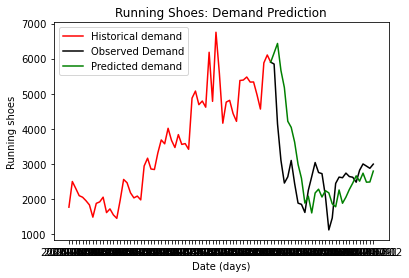

In [16]:
plt.plot(historical_demand, color = 'red', label = 'Historical demand')
plt.plot(obs_demand, color = 'black', label = 'Observed Demand')
plt.plot(pred_demand, color = 'green', label = 'Predicted demand')
plt.title('Running Shoes: Demand Prediction')
plt.xlabel('Date (days)')
plt.ylabel('Running shoes')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error

In [20]:
mean_absolute_error(obs_demand, pred_demand)

752.0675915133569